In [1]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

In [2]:
! pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.5 MB/s eta 0:00:00


In [3]:
import argparse
gpus = [0]
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, gpus))
import math
import glob
import random
import itertools
import datetime
import time
import datetime
import sys
import scipy.io

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchsummary import summary
import torch.autograd as autograd
from torchvision.models import vgg19

import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn.init as init

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F

from torch import nn
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# from common_spatial_pattern import csp

# from torch.utils.tensorboard import SummaryWriter
from torch.backends import cudnn
cudnn.benchmark = False
cudnn.deterministic = True

# Import data

In [2]:
# mount to google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


test data shape (443, 22, 1000)
train data shape (2115, 22, 1000)


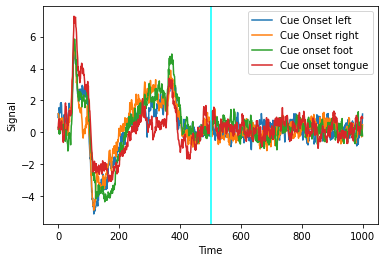

In [4]:
# Loading and visualizing the data

## Loading the dataset
data_path="/content/drive/My Drive/Colab Notebooks/egg_data/"

X_test = np.load(os.path.join(data_path,"X_test.npy"))
y_test = np.load(os.path.join(data_path,"y_test.npy"))
person_train_valid = np.load(os.path.join(data_path,"person_train_valid.npy"))
X_train_valid = np.load(os.path.join(data_path,"X_train_valid.npy"))
y_train_valid = np.load(os.path.join(data_path,"y_train_valid.npy"))
person_test = np.load(os.path.join(data_path,"person_test.npy"))

print('test data shape', X_test.shape)
print('train data shape', X_train_valid.shape)

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3
y_train_valid -= 769
y_test -= 769

## Visualizing the data
ch_data = X_train_valid[:,1,:] # extracts the 9th channel from the data

class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0

class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')
plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()

# Data preprocessing

In [7]:
def data_prep(X,y, person, sub_sample,average,noise):
    
    total_X = None
    total_y = None
    total_p = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    total_y = y
    total_p = person
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_p = np.vstack((total_p, person))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_p = np.vstack((total_p, person))
  
    print('Shape of X after subsampling and concatenating:',total_X.shape)

    # Normalization
    X_scaled = zscore(total_X)

    return X_scaled,total_y,total_p


X_train_valid_prep,y_train_valid_prep,person_train_valid_prep = data_prep(X_train_valid,y_train_valid,person_train_valid,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [8]:
def data_prep2(X,y):
    X_scaled = zscore(X)
    return X_scaled,y  

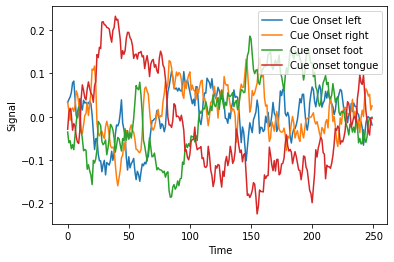

In [11]:
## Visualizing the data after preprocessing
ch_data = X_train_valid_prep[:,0,:] # extracts the 9th channel from the data

class_0_ind = np.where(y_train_valid_prep == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0

class_1_ind = np.where(y_train_valid_prep == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid_prep == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid_prep == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(250),avg_ch_data_class_0)
plt.plot(np.arange(250),avg_ch_data_class_1)
plt.plot(np.arange(250),avg_ch_data_class_2)
plt.plot(np.arange(250),avg_ch_data_class_3)
plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()

# Build training, validation, testing datasets

In [9]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

(person_train, person_valid) = person_train_valid[ind_train], person_train_valid[ind_valid]

## Preprocessing the dataset
x_train,y_train, person_train = data_prep(X_train,y_train,person_train,2,2,True)
x_valid,y_valid, person_valid = data_prep(X_valid,y_valid,person_valid,2,2,True)
X_test_prep,y_test_prep, person_test_prep = data_prep(X_test,y_test,person_test,2,2,True)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)
print('Shape of person train', person_train.shape)
print('Shape of person valid', person_valid.shape)
print('Shape of person test', person_test_prep.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

In [10]:
# Extract personal data
person_train = person_train.reshape(len(person_train))
person_valid = person_valid.reshape(len(person_valid))
person_test_prep = person_test_prep.reshape(len(person_test_prep))
ind = np.where(person_train == 0) # finds the indices where the label is 0
x_train_person1 = x_train[ind]
y_train_person1 = y_train[ind]
ind2 = np.where(person_valid == 0)
x_valid_person1 = x_valid[ind2]
y_valid_person1 = y_valid[ind2]
ind3 = np.where(person_test_prep == 0)
x_test_person1 = x_test[ind3]
y_test_person1 = y_test[ind3]
print(x_train_person1.shape)
print(y_train_person1.shape)
print(x_valid_person1.shape)
print(y_valid_person1.shape)
print(x_test_person1.shape)
print(y_test_person1.shape)

(780, 250, 1, 22)
(780, 4)
(168, 250, 1, 22)
(168, 4)
(200, 250, 1, 22)
(200, 4)


In [12]:
## Build data for transformer model

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
(person_train_tf, person_valid_tf) = person_train_valid[ind_train], person_train_valid[ind_valid]

x_train_tf,y_train_tf = data_prep2(X_train,y_train)
x_valid_tf,y_valid_tf = data_prep2(X_valid,y_valid)
X_test_tf,y_test_tf = data_prep2(X_test,y_test)
person_test_tf = person_test
print('Shape of testing set:',X_test_tf.shape)
print('Shape of testing labels:',y_test_tf.shape)

print('Shape of training set:',x_train_tf.shape)
print('Shape of validation set:',x_valid_tf.shape)
print('Shape of training labels:',y_train_tf.shape)
print('Shape of validation labels:',y_valid_tf.shape)


# Converting the labels to categorical variables for multiclass classification
#y_train_tf = to_categorical(y_train_tf, 4)
#y_valid_tf = to_categorical(y_valid_tf, 4)
#y_test_tf = to_categorical(y_test_tf, 4)
print('Shape of training labels after categorical conversion:',y_train_tf.shape)
print('Shape of validation labels after categorical conversion:',y_valid_tf.shape)
print('Shape of test labels after categorical conversion:',y_test_tf.shape)

x_train_tf = x_train_tf.reshape(-1, 1, x_train_tf.shape[1], x_train_tf.shape[2])
x_valid_tf = x_valid_tf.reshape(-1, 1, x_valid_tf.shape[1], x_valid_tf.shape[2])
x_test_tf = X_test_tf.reshape(-1, 1, X_test_tf.shape[1], X_test_tf.shape[2])
print('Shape of training set after adding width info:',x_train_tf.shape)
print('Shape of validation set after adding width info:',x_valid_tf.shape)
print('Shape of test set after adding width info:',x_test_tf.shape)
print('Shape of person train', person_train_tf.shape)
print('Shape of person valid', person_valid_tf.shape)
print('Shape of person test', person_test_tf.shape)

Shape of testing set: (443, 22, 1000)
Shape of testing labels: (443,)
Shape of training set: (1740, 22, 1000)
Shape of validation set: (375, 22, 1000)
Shape of training labels: (1740,)
Shape of validation labels: (375,)
Shape of training labels after categorical conversion: (1740,)
Shape of validation labels after categorical conversion: (375,)
Shape of test labels after categorical conversion: (443,)
Shape of training set after adding width info: (1740, 1, 22, 1000)
Shape of validation set after adding width info: (375, 1, 22, 1000)
Shape of test set after adding width info: (443, 1, 22, 1000)
Shape of person train (1740, 1)
Shape of person valid (375, 1)
Shape of person test (443, 1)


In [13]:
person_train_tf = person_train_tf.reshape(len(person_train_tf))
person_valid_tf = person_valid_tf.reshape(len(person_valid_tf))
person_test_tf = person_test_tf.reshape(len(person_test_tf))
ind = np.where(person_train_tf == 0) # finds the indices where the label is 0
x_train_tf_person1 = x_train_tf[ind]
y_train_tf_person1 = y_train_tf[ind]
ind2 = np.where(person_valid_tf == 0)
x_valid_tf_person1 = x_valid_tf[ind2]
y_valid_tf_person1 = y_valid_tf[ind2]
ind3 = np.where(person_test_tf == 0)
x_test_tf_person1 = x_test_tf[ind3]
y_test_tf_person1 = y_test_tf[ind3]
print(x_train_tf_person1.shape)
print(y_train_tf_person1.shape)
print(x_valid_tf_person1.shape)
print(y_valid_tf_person1.shape)
print(x_test_tf_person1.shape)
print(y_test_tf_person1.shape)

(193, 1, 22, 1000)
(193,)
(44, 1, 22, 1000)
(44,)
(50, 1, 22, 1000)
(50,)


# Model construction

CNN

In [11]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

CNN + LSTM

In [27]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(30, dropout=0.5, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 1, 50)       

Transformer

In [14]:
"""
EEG Conformer 
Convolutional Transformer for EEG decoding
Couple CNN and Transformer in a concise manner with amazing results
"""

# Convolution module
# use conv to capture local features, instead of postion embedding.
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        # self.patch_size = patch_size
        super().__init__()

        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.Conv2d(40, 40, (22, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.AvgPool2d((1, 75), (1, 15)),  # pooling acts as slicing to obtain 'patch' along the time dimension as in ViT
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  # transpose, conv could enhance fiting ability slightly
            Rearrange('b e (h) (w) -> b (h w) e'),
        )


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.shallownet(x)
        x = self.projection(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return input*0.5*(1.0+torch.erf(input/math.sqrt(2.0)))


class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=10,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        
        # global average pooling
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )
        self.fc = nn.Sequential(
            nn.Linear(2440, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 32),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = self.fc(x)
        return x, out


class Conformer(nn.Sequential):
    def __init__(self, emb_size=40, depth=6, n_classes=4, **kwargs):
        super().__init__(

            PatchEmbedding(emb_size),
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, n_classes)
        )


In [15]:
print(torch.cuda.is_available())
device_id = 0 if torch.cuda.is_available() else 'cpu' # Equivalent to device_id = 'cuda:0'
device = torch.device(device_id) # use these semantics to specify a specific device. 

True


In [19]:
model = Conformer()
model = model.to(device)
print(model)

Conformer(
  (0): PatchEmbedding(
    (shallownet): Sequential(
      (0): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1))
      (1): Conv2d(40, 40, kernel_size=(22, 1), stride=(1, 1))
      (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 75), stride=(1, 15), padding=0)
      (5): Dropout(p=0.5, inplace=False)
    )
    (projection): Sequential(
      (0): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
  )
  (1): TransformerEncoder(
    (0): TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (keys): Linear(in_features=40, out_features=40, bias=True)
            (queries): Linear(in_features=40, out_features=40, bias=True)
            (values): Linear(in_features=40, out_features=40, bias=True

# Training

cnn

In [23]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [24]:
def scheduler(epoch, lr):
  if epoch < 25:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'CNN/cp2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Training and validating the model
start = time.time()
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             callbacks=[model_checkpoint_callback,lr_callback],
             validation_data=(x_valid, y_valid), verbose=True)
print("Total time: ", time.time() - start, "seconds")

In [ ]:
#basic_cnn_model.save('CNN/checkpoint_last')

In [21]:
#from keras.models import load_model
#basic_cnn_model= load_model('CNN/cp2')

cnn + lstm

In [34]:
# Model parameters
learning_rate = 5e-4
epochs = 50
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [35]:
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer= hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'CNN_LSTM/cp2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

# Training and validating the model
start2 = time.time()
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             callbacks=[model_checkpoint_callback, lr_callback],
             validation_data=(x_valid, y_valid), verbose=True)
print("Total time: ", time.time() - start2, "seconds")

In [ ]:
#hybrid_cnn_lstm_model.save('CNNLSTM/ck')

In [32]:
#from keras.models import load_model
#hybrid_cnn_lstm_model= load_model(checkpoint_filepath)

transformer

In [20]:
class ExP():
    def __init__(self,model):
        super(ExP, self).__init__()
        self.batch_size = 72
        self.n_epochs = 50
        self.c_dim = 4
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.dimension = (190, 50)
       

        self.start_epoch = 0
        #self.root = '/Data/strict_TE/'

        #self.log_write = open("./results/log_subject%d.txt" % self.nSub, "w")


        self.Tensor = torch.cuda.FloatTensor
        self.LongTensor = torch.cuda.LongTensor

        self.criterion_l1 = torch.nn.L1Loss().to(device)
        self.criterion_l2 = torch.nn.MSELoss().to(device)
        self.criterion_cls = torch.nn.CrossEntropyLoss().to(device)

        #self.model = Conformer().to(device)
        #self.model = nn.DataParallel(self.model, device_ids=[i for i in range(len(gpus))])
        #self.model = self.model.to(device)
        # summary(self.model, (1, 22, 1000))
        self.model = model


    def train(self, img, label, test_data, test_label):

        #img, label, test_data, test_label = self.get_source_data()

        img = torch.from_numpy(img)
        label = torch.from_numpy(label)

        dataset = torch.utils.data.TensorDataset(img, label)
        self.dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)

        test_data = torch.from_numpy(test_data)
        test_label = torch.from_numpy(test_label)
        test_dataset = torch.utils.data.TensorDataset(test_data, test_label)
        self.test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=True)

        # Optimizers
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.b1, self.b2))

        test_data = Variable(test_data.type(self.Tensor))
        test_label = Variable(test_label.type(self.LongTensor))

        bestAcc = 0
        averAcc = 0
        num = 0
        Y_true = 0
        Y_pred = 0

        # Train the cnn model
        total_step = len(self.dataloader)
        curr_lr = self.lr

        train_loss_lst = []
        val_loss_lst = []
        train_acc_lst = []
        val_acc_lst = []

        start3 = time.time()

        for e in range(self.n_epochs):
            in_epoch = time.time()
            self.model.train()
            for i, (img, label) in enumerate(self.dataloader):

                img = Variable(img.to(device).type(self.Tensor))
                label = Variable(label.to(device).type(self.LongTensor))


                tok, outputs = self.model(img)

                loss = self.criterion_cls(outputs, label) 

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()



            # test process
            if (e + 1) % 1 == 0:
                self.model.eval()
                Tok, Cls = self.model(test_data)


                loss_test = self.criterion_cls(Cls, test_label)
                y_pred = torch.max(Cls, 1)[1]
                acc = float((y_pred == test_label).cpu().numpy().astype(int).sum()) / float(test_label.size(0))
                train_pred = torch.max(outputs, 1)[1]
                train_acc = float((train_pred == label).cpu().numpy().astype(int).sum()) / float(label.size(0))
                train_loss_lst.append(loss.detach().cpu().numpy())
                val_loss_lst.append(loss_test.detach().cpu().numpy())
                train_acc_lst.append(train_acc)
                val_acc_lst.append(acc)

                end_epoch = time.time() - in_epoch
                print('Epoch:', e,
                      '  Train loss: %.6f' % loss.detach().cpu().numpy(),
                      '  Test loss: %.6f' % loss_test.detach().cpu().numpy(),
                      '  Train accuracy %.6f' % train_acc,
                      '  Test accuracy is %.6f' % acc,
                      'Time(s) is %.4f' % end_epoch)

                #self.log_write.write(str(e) + "    " + str(acc) + "\n")
                num = num + 1
                averAcc = averAcc + acc
                if acc > bestAcc:
                    bestAcc = acc
                    Y_true = test_label
                    Y_pred = y_pred
                    torch.save(self.model.state_dict(), 'Trans_model.pth')

        averAcc = averAcc / num
        print('The average accuracy is:', averAcc)
        print('The best accuracy is:', bestAcc)
        print('Total time is:', time.time()- start3,'seconds')
        #self.log_write.write('The average accuracy is: ' + str(averAcc) + "\n")
        #self.log_write.write('The best accuracy is: ' + str(bestAcc) + "\n")

        return self.model, train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst, Y_true, Y_pred
        # writer.close()


In [ ]:
exp = ExP(model)
model, train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst, _, _ = exp.train(x_train_tf,y_train_tf,x_valid_tf,y_valid_tf)

In [134]:
#torch.save(model.state_dict(), 'Trans_model_last.pth')

In [138]:
#model.load_state_dict(torch.load('Trans_model.pth'))

<All keys matched successfully>

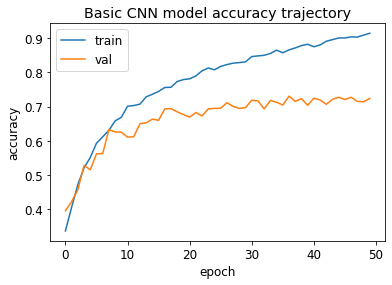

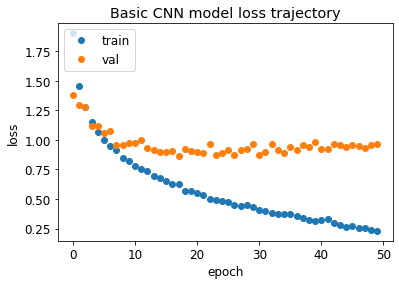

In [162]:

# Plotting accuracy trajectory
plt.rcParams.update({'font.size':12})
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('CNN_training_accu.pdf')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("CNN_training.pdf")
plt.show()

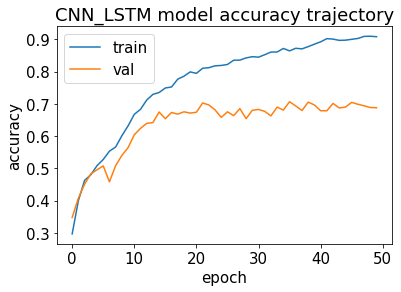

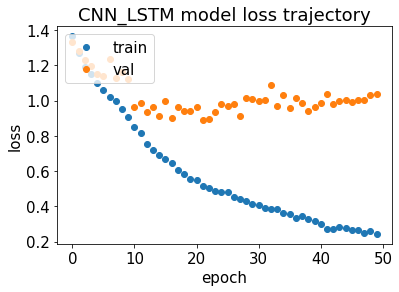

In [194]:
# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('CNN_LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('CNNLSTM_training_accu.pdf')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('CNN_LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("CNNLSTM_training.pdf")
plt.show()

In [ ]:
# Plotting accuracy trajectory
x = np.arange(len(train_acc_lst)) + 50
plt.plot(x,train_acc_lst)
plt.plot(x,val_acc_lst)
plt.title('Transformer model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Transformer_training_accu.pdf')
plt.show()

# Plotting loss trajectory
plt.plot(x,train_loss_lst,'o')
plt.plot(x,val_loss_lst,'o')
plt.title('Transformer model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Transformer_training.pdf")
plt.show()

# Testing

CNN

In [ ]:
## Testing the basic CNN model
cnn_score_person1 = basic_cnn_model.evaluate(x_test_person1, y_test_person1, verbose=0)
cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
cnn_pred = basic_cnn_model.predict(x_test)
print('Test accuracy of the basic CNN model on person1:',cnn_score_person1[1])
print('Test accuracy of the basic CNN model:',cnn_score[1])
cnn_pred_class = np.zeros_like(cnn_pred)
cnn_pred_class[np.arange(len(cnn_pred)), cnn_pred.argmax(1)] = 1

In [211]:
from sklearn.metrics import accuracy_score
def accu_person(y_test, cnn_pred_class, person_test_prep, cnn_score):
  y_test_person = []
  cnn_pred_person = []
  cnn_pred_accu = []
  for i in range(9):
    ind = np.where(person_test_prep == i) # finds the indices where the label is 0
    y_test_p = y_test[ind]
    y_test_person.append(y_test_p)
    cnn_pred_p = cnn_pred_class[ind]
    cnn_pred_person.append(cnn_pred_p)
    accu = accuracy_score(y_test_p.argmax(axis=1), cnn_pred_p.argmax(axis =1))
    cnn_pred_accu.append(accu)
  cnn_pred_accu.append(cnn_score[1])
  print(cnn_pred_accu)
  fig = plt.figure(figsize = (6,4))
  plt.rcParams.update({'font.size':15})
  ax = fig.add_axes([0,0,1,1])
  methods = ['S1', 'S2','S3','S4','S5','S6','S7', 'S8', 'S9','Avg']
  x_pos = np.arange(len(methods))
  plt.bar(x_pos, cnn_pred_accu)
  plt.xticks(x_pos,methods)
  plt.ylabel('Accuracy', fontsize = 15)
  plt.savefig('Person_accuracy.pdf')
  plt.show()
  return y_test_person, cnn_pred_person, cnn_pred_accu

[0.66, 0.645, 0.815, 0.705, 0.776595744680851, 0.6428571428571429, 0.685, 0.68, 0.7446808510638298, 0.7054176330566406]


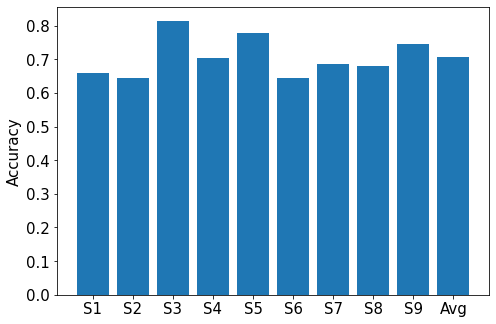

In [212]:
y_test_person, cnn_pred_person, cnn_pred_accu = accu_person(y_test, cnn_pred_class, person_test_prep, cnn_score)


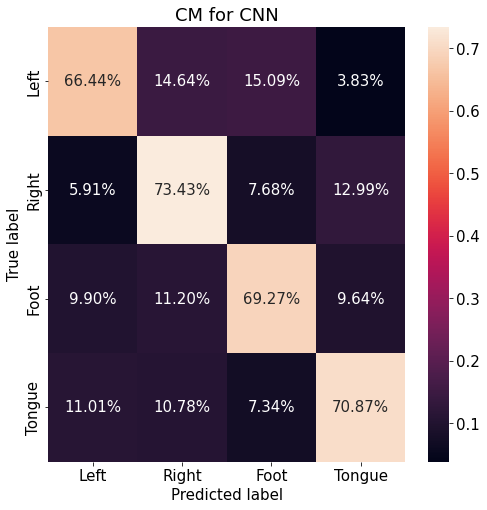

In [181]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), cnn_pred_class.argmax(axis=1), labels = [0,1,2,3], normalize = 'true')
display_labels= ['Left','Right','Foot','Tongue']
df_cm = pd.DataFrame(cm,index = [i for i in display_labels], columns =[i for i in display_labels])
plt.figure(figsize = (8,8))
plt.rcParams.update({'font.size':15})                              
plt.title("CM for CNN")
sns.heatmap(df_cm,annot = True, fmt = '.2%')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("CM_CNN.pdf")
plt.show()

In [213]:
from sklearn.metrics import precision_recall_fscore_support
def metricplot(y_test, cnn_pred_class, cnn_score):
  cnn_s2 = precision_recall_fscore_support(y_test.argmax(axis=1), cnn_pred_class.argmax(axis=1), average='macro')
  #cnn_s3 = precision_recall_fscore_support(y_test.argmax(axis=1), cnn_pred_class.argmax(axis=1), average=None)
  #print('average_prec, recall, f1', cnn_s2)
  cnn_s_lst = []
  for i in range(3):
    cnn_s_lst.append(cnn_s2[i])
  cnn_s_lst.append(cnn_score[1])
  print(cnn_s_lst)
  fig = plt.figure(figsize = (6,4))
  plt.rcParams.update({'font.size':15})
  ax = fig.add_axes([0,0,1,1])
  methods = ['Precision','Recall','F1_score','Accuracy']
  x_pos = np.arange(len(methods))
  plt.bar(x_pos, cnn_s_lst)
  plt.xticks(x_pos,methods)
  plt.ylabel('Score', fontsize = 15)
  plt.savefig('Person_metric.pdf')
  plt.show()
  return cnn_s_lst

[0.7032326638424516, 0.7047867183579954, 0.7035247452492792, 0.7054176330566406]


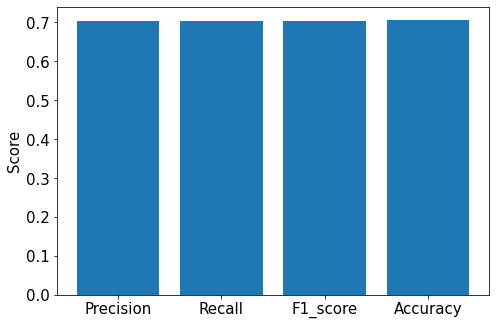

In [214]:
cnn_s_lst = metricplot(y_test, cnn_pred_class, cnn_score)

CNN-LSTM

In [37]:
cnn_lstm_score_person1 = hybrid_cnn_lstm_model.evaluate(x_test_person1, y_test_person1, verbose=0)
cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN_LSTM model on subject 1:',cnn_lstm_score_person1[1])
print('Test accuracy of the CNN_LSTM model:',cnn_lstm_score[1])
cnn_lstm_pred = hybrid_cnn_lstm_model.predict(x_test)
cnn_lstm_pred_class = np.zeros_like(cnn_lstm_pred)
cnn_lstm_pred_class[np.arange(len(cnn_lstm_pred)), cnn_lstm_pred.argmax(1)] = 1

Test accuracy of the CNN_LSTM model on subject 1: 0.4950000047683716
Test accuracy of the CNN_LSTM model: 0.6281038522720337
56/56 [==============================] - 4s 30ms/step


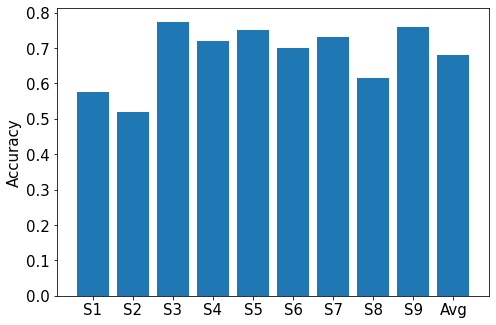

In [196]:
y_test_person, cnn_lstm_pred_person, cnn_lstm_pred_accu = accu_person(y_test, cnn_lstm_pred_class, person_test_prep, cnn_lstm_score)

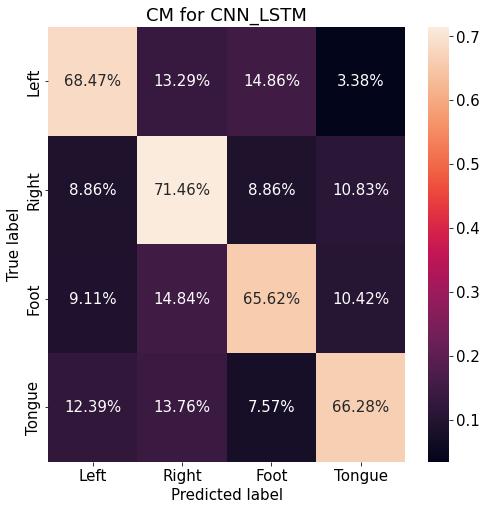

In [197]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), cnn_lstm_pred_class.argmax(axis=1), labels = [0,1,2,3], normalize = 'true')
display_labels= ['Left','Right','Foot','Tongue']
df_cm = pd.DataFrame(cm,index = [i for i in display_labels], columns =[i for i in display_labels])
plt.figure(figsize = (8,8))
plt.rcParams.update({'font.size':15})                              
plt.title("CM for CNN_LSTM")
sns.heatmap(df_cm,annot = True, fmt = '.2%')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("CM_CNN_LSTM.pdf")
plt.show()

[0.6820519320004333, 0.6795864126289477, 0.6802803901911458, 0.6817155480384827]


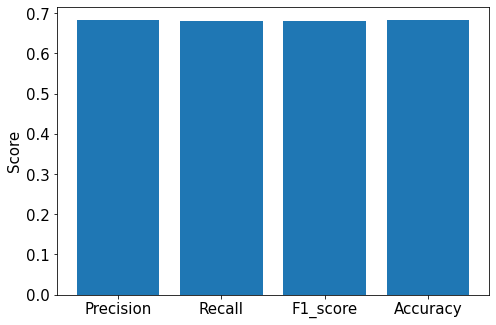

In [201]:
cnn_lstm_s_lst = metricplot(y_test, cnn_lstm_pred_class, cnn_lstm_score)

Transformer

In [69]:
test_data = torch.from_numpy(x_test_tf)
test_label = torch.from_numpy(y_test_tf)
test_data = Variable(test_data.type(torch.cuda.FloatTensor))
test_label = Variable(test_label.type(torch.cuda.LongTensor))

In [141]:
model.eval()
Tok, Cls = model(test_data)
y_pred = torch.max(Cls, 1)[1]
y_pred_np = y_pred.cpu().numpy().astype(int)

In [ ]:
acc = float((y_pred == test_label).cpu().numpy().astype(int).sum()) / float(test_label.size(0))
print("Transformer accuracy",acc)

In [72]:
from sklearn.metrics import accuracy_score
def accu_person2(y_test, y_pred, person_test_tf, acc_avg):
  y_test_person = []
  y_pred_person = []
  y_pred_accu = []
  for i in range(9):
    ind = np.where(person_test_tf == i) # finds the indices where the label is 0
    y_test_p = y_test[ind]
    y_test_person.append(y_test_p)
    y_pred_p = y_pred[ind]
    y_pred_person.append(y_pred_p)
    accu = accuracy_score(y_test_p, y_pred_p)
    y_pred_accu.append(accu)
  y_pred_accu.append(acc_avg)
  print(y_pred_accu)
  fig = plt.figure(figsize = (6,4))
  plt.rcParams.update({'font.size':15})
  ax = fig.add_axes([0,0,1,1])
  methods = ['S1', 'S2','S3','S4','S5','S6','S7', 'S8', 'S9','Avg']
  x_pos = np.arange(len(methods))
  plt.bar(x_pos, y_pred_accu)
  plt.xticks(x_pos,methods)
  plt.ylabel('Accuracy', fontsize = 15)
  plt.savefig('Person_accuracy.pdf')
  plt.show()
  return y_test_person, y_pred_person, y_pred_accu

[0.58, 0.56, 0.76, 0.58, 0.7021276595744681, 0.673469387755102, 0.66, 0.54, 0.7021276595744681, 0.6388261851015802]


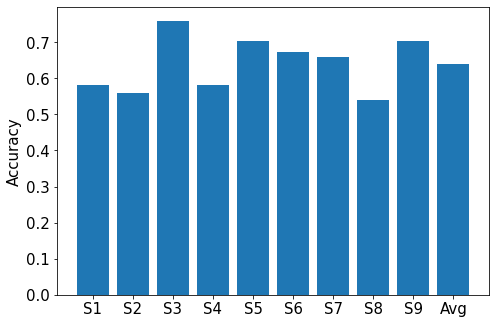

In [131]:
y_test_person, y_pred_person, y_pred_accu = accu_person2(y_test_tf, y_pred_np, person_test_tf, acc)

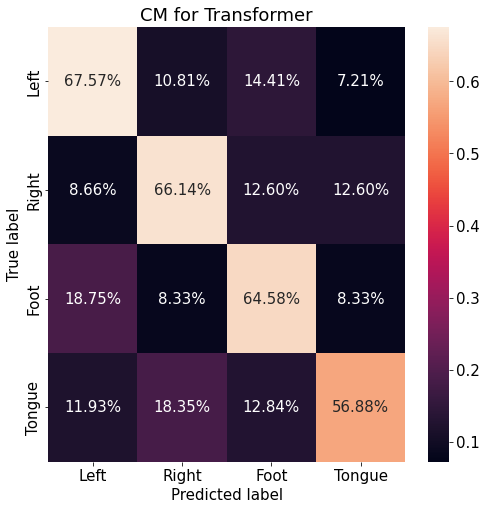

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_tf, y_pred_np, labels = [0,1,2,3], normalize = 'true')
display_labels= ['Left','Right','Foot','Tongue']
df_cm = pd.DataFrame(cm,index = [i for i in display_labels], columns =[i for i in display_labels])
plt.figure(figsize = (8,8))
plt.rcParams.update({'font.size':15})                              
plt.title("CM for Transformer")
sns.heatmap(df_cm,annot = True, fmt = '.2%')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("CM_Transformer_best.pdf")
plt.show()

In [61]:
from sklearn.metrics import precision_recall_fscore_support
def metricplot2(y_test, y_pred, acc_avg):
  s2 = precision_recall_fscore_support(y_test, y_pred, average='macro')
  s_lst = []
  for i in range(3):
    s_lst.append(s2[i])
  s_lst.append(acc_avg)
  print(s_lst)
  fig = plt.figure(figsize = (6,4))
  plt.rcParams.update({'font.size':15})
  ax = fig.add_axes([0,0,1,1])
  methods = ['Precision','Recall','F1_score','Accuracy']
  x_pos = np.arange(len(methods))
  plt.bar(x_pos, s_lst)
  plt.xticks(x_pos,methods)
  plt.ylabel('Score', fontsize = 15)
  plt.savefig('Person_metric.pdf')
  plt.show()
  return s_lst

[0.6380233845058828, 0.637933417823299, 0.6364745054209997, 0.6388261851015802]


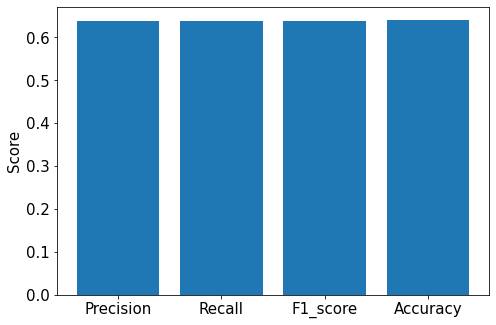

In [133]:
s_lst = metricplot2(y_test_tf, y_pred_np, acc)